In [22]:
# Import and concat the data
# preprocess into multiclass problem
# make a function to train multiple models 
# Make function to eval multiple models
# make function to train models on diferent seasons

In [23]:
import pandas as pd

In [24]:
#import match data for EPL season 2020 - 2021
matches_20_22 = pd.read_csv(r"C:\Users\w126311\#Personal\Jupyter Notebook\Premier leauge prediction\Backtest\prem_20_22.csv")
matches_23 = pd.read_csv(r"C:\Users\w126311\#Personal\Jupyter Notebook\Premier leauge prediction\matches.csv")


In [25]:
# Convert column names to lowercase
matches_20_22.columns = [column.lower() for column in matches_20_22.columns]
matches_23.columns = [column.lower() for column in matches_23.columns]

# Reorder columns in matches_20_22 to match the order in matches_23
matches_20_22 = matches_20_22.reindex(columns=matches_23.columns)

# Concatenate the two DataFrames
matches = pd.concat([matches_20_22, matches_23], ignore_index=True)

# Display the combined DataFrame
matches.head()

,unnamed: 0,index,date,time,comp,round,day,venue,result,gf,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,NaN,2021-08-07,17:15,Community Shield,FA Community Shield,Sat,Neutral,L,0,...,Match Report,NaN,12.0,3.0,NaN,NaN,0,0,2022,Manchester City
1,1,NaN,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0,...,Match Report,NaN,18.0,4.0,17.3,1.0,0,0,2022,Manchester City
2,2,NaN,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5,...,Match Report,NaN,16.0,4.0,18.5,1.0,0,0,2022,Manchester City
3,3,NaN,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5,...,Match Report,NaN,25.0,10.0,14.8,0.0,0,0,2022,Manchester City
4,4,NaN,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1,...,Match Report,NaN,25.0,8.0,14.3,0.0,0,0,2022,Manchester City


### 1.Transform Data
- filter to only see Premier Leauge rows
- Encode Categorical columns
- Eliminate nulls

- filter out draws

In [26]:
# filter for only prem matches
matches['comp'] = matches['comp'][matches['comp'] == 'Premier League']
matches = matches.dropna(subset=['comp'])

In [27]:
# encode data


matches['date'] = pd.to_datetime(matches['date'])
matches['day_code'] = matches['date'].dt.dayofweek
matches['month_code'] = matches['date'].dt.month
matches['hour'] = matches['time'].str.replace(":.+","",regex=True).astype('int') 
matches['venue_code'] = matches['venue'].astype('category').cat.codes
matches['referee'] = matches['referee'].astype('category').cat.codes
matches['opponent_code'] = matches['opponent'].astype('category').cat.codes 

# Filter out draws
matches = matches[matches['result'] != 'D']
matches['label'] = (matches['result']=="W").astype('category').cat.codes



columns_to_keep = ['day_code', 'month_code', 'hour', 'venue_code',
        'opponent_code']

### 2. Feature engineering

In [28]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    
    return group


In [29]:
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
rolling_cols = [f"{c}_rolling" for c in cols]

In [30]:
#run function to add rolling averages 
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, rolling_cols))
#drop level to be able to index by column not team
matches_rolling.droplevel('team')
#reset index
matches_rolling.index = range(matches_rolling.shape[0])


### 3.EDA
- Vizualize the amount of wins draws and losses there is in each partition of the dataset

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Define columns to use
pred_columns = columns_to_keep+rolling_cols+['label']+['season']
train_df = matches_rolling[pred_columns].dropna()

#split the train_df into the 2 seasons
#Filter on season column
df_2020 = train_df[train_df['season']==2020]
df_2021 = train_df[train_df['season']==2021]
df_2022 = train_df[train_df['season']==2022]
df_2023 = train_df[train_df['season']==2023]

season_partitions = [df_2020,df_2021,df_2022,df_2023]

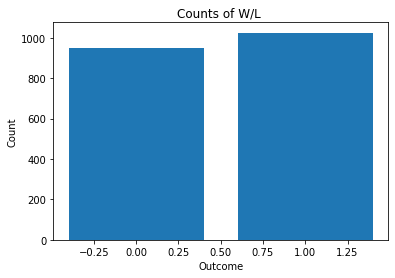

In [12]:

#count diferent outcomes
label_counts = train_df['label'].value_counts()

# Create a bar plot
plt.bar(x=label_counts.index, height=label_counts.values)

# Add labels and title
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title(f'Counts of W/L ')

# Show plot
plt.show()

    


# 3.1 
given poor model performance I have removed draws to imporve performance 

### 4. Train and Predict

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [14]:
def train_predict(models,partitions):
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
    """
    This function trains a given model on diferent partitions of data
    """

    # Initialize empty lists to store values
    model_name = []
    seasons = []
    accuracies = []
    precisions = []
    true_negatives_list = []
    false_positives_list = []
    false_negatives_list = []
    true_positives_list = []
    precision_w = []
    #precision_d = []
    precision_l = []



    for model in models:
        
        for partition in partitions:
            #train test split
            train_x, test_x, train_y, test_y = train_test_split(partition.drop(columns=['label','season']), partition['label'], 
                                                        test_size=0.20, random_state=42,shuffle=False)
            #train and predict
            model.fit(train_x,train_y)
            preds = model.predict(test_x)

            #Evaluate model
            season = partition['season'].iloc[0]
            #precision score
            precision = precision_score(test_y,preds,average = None)
            #accuracy score
            acc = accuracy_score(test_y,preds)
            #confusion matrix
            cm = confusion_matrix(test_y,preds)
            true_negatives = cm[0, 0]
            false_positives = cm[0, 1]
            false_negatives = cm[1, 0]
            true_positives = cm[1, 1]

            # Append values to respective lists
            model_name.append(type(model).__name__)
            seasons.append(season)
            accuracies.append(acc)
            precisions.append(precision)
            true_negatives_list.append(true_negatives)
            false_positives_list.append(false_positives)
            false_negatives_list.append(false_negatives)
            true_positives_list.append(true_positives)
            precision_w.append(precision[0])
            precision_l.append(precision[1])


            
    # Create DataFrame using the lists
    df = pd.DataFrame({
        'model':model_name,
        'Season': seasons,
        'Accuracy': accuracies,
        'Precision Wins': precision_w,
        'Precision Loss': precision_l,
        'True Negatives': true_negatives_list,
        'False Positives': false_positives_list,
        'False Negatives': false_negatives_list,
        'True Positives': true_positives_list
    })
    
    return df

gb_model = GradientBoostingClassifier(random_state=30)
rf_model = RandomForestClassifier(random_state=30)
lr_model = LogisticRegression(random_state=30,multi_class='auto',max_iter=1000)
models = [rf_model,lr_model,gb_model]
evaluation_df = train_predict(models,season_partitions)

In [15]:
evaluation_df

,model,Season,Accuracy,Precision Wins,Precision Loss,True Negatives,False Positives,False Negatives,True Positives
0,RandomForestClassifier,2020,0.596154,0.597015,0.594595,40,15,27,22
1,RandomForestClassifier,2021,0.512821,0.528571,0.489362,37,24,33,23
2,RandomForestClassifier,2022,0.564103,0.589041,0.522727,43,21,30,23
3,RandomForestClassifier,2023,0.728814,0.818182,0.708333,9,14,2,34
4,LogisticRegression,2020,0.567308,0.589286,0.541667,33,22,23,26
5,LogisticRegression,2021,0.461538,0.483871,0.436364,30,31,32,24
6,LogisticRegression,2022,0.623932,0.642857,0.595745,45,19,25,28
7,LogisticRegression,2023,0.711864,0.750000,0.702128,9,14,3,33
8,GradientBoostingClassifier,2020,0.663462,0.651515,0.684211,43,12,23,26
9,GradientBoostingClassifier,2021,0.547009,0.558824,0.530612,38,23,30,26


### 5. Prediction Table
- find the best performing model using the precision as a metric
- Create a prediction column for the backtesting on all the data

In [16]:
evaluation_df.groupby('model').agg({'Precision Wins':'mean',
                                   'Precision Loss':'mean',
                                   'Accuracy':'mean'})

,Precision Wins,Precision Loss,Accuracy
model,,,
GradientBoostingClassifier,0.637389,0.624194,0.632257
LogisticRegression,0.616503,0.568976,0.591161
RandomForestClassifier,0.633202,0.578754,0.600473


Rndom Forest is better at predicting with draws 

GBC has the best results accross the board

# Train and Predict

In [17]:
#train rf on 3 seasons of data and predict on 1
# Grid search on rf 

In [18]:
# Split the data to train on 3 seasons and predict on 2022
train_df = train_df[train_df['season'] != 2022]
test_df = df_2022

train_x = train_df.drop(columns = ['season','label'])
train_y = train_df['label']

test_x = test_df.drop(columns = ['season','label'])
test_y = test_df['label']

In [19]:
train_x

,day_code,month_code,hour,venue_code,opponent_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,6,9,16,1,1,1.333333,1.333333,10.666667,4.666667,17.200000,0.333333,0.000000,0.000000
1,6,10,14,1,2,2.000000,2.000000,14.666667,5.666667,18.200000,1.000000,0.333333,0.333333
2,0,10,20,0,18,1.666667,1.666667,13.666667,3.333333,17.066667,1.000000,0.333333,0.333333
3,5,11,17,0,11,1.333333,1.000000,13.666667,3.333333,17.000000,1.000000,0.333333,0.333333
4,3,12,20,1,4,0.333333,1.000000,9.666667,2.000000,16.633333,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970,5,4,15,1,3,1.000000,0.666667,11.333333,3.333333,17.666667,0.000000,0.000000,0.000000
1971,5,4,15,0,11,1.000000,0.333333,11.333333,6.000000,17.566667,0.000000,0.000000,0.000000
1972,5,4,15,0,4,1.333333,0.666667,11.666667,5.666667,20.033333,0.666667,0.000000,0.000000
1973,5,5,15,0,14,1.000000,2.666667,12.333333,4.666667,19.266667,0.666667,0.000000,0.000000


C:\Users\w126311\AppData\Local\Temp\ipykernel_5668\1301892579.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


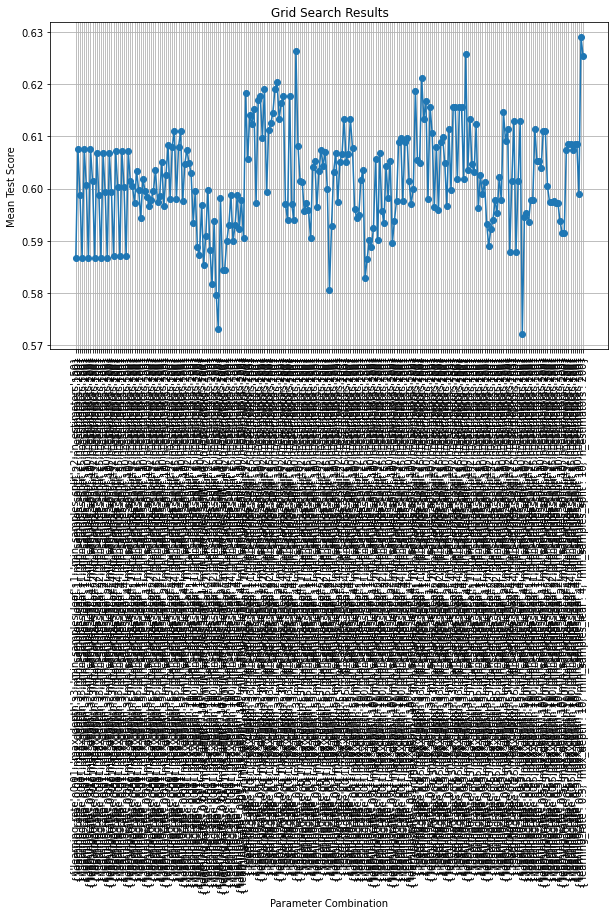

Best Parameters: {'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Gradient Boosting classifier
gb_model = GradientBoostingClassifier(random_state=30)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='precision', return_train_score=True)

# Perform grid search on the data
grid_search.fit(train_x[0:1000], train_y[0:1000])

# Get mean test scores and parameters
mean_test_scores = grid_search.cv_results_['mean_test_score']
params = grid_search.cv_results_['params']

# Visualize the training process
plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_test_scores)), mean_test_scores, marker='o', linestyle='-')
plt.xlabel('Parameter Combination')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results')
plt.xticks(range(len(mean_test_scores)), [str(params[i]) for i in range(len(mean_test_scores))], rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

In [52]:
from sklearn.metrics import precision_score

#train and predict on the best model
model = grid_search.best_estimator_

model.fit(train_x,train_y)
preds = model.predict(test_x)
probability = model.predict_proba(test_x)

#precision
print(precision_score(test_y,preds,average = None))

#create combined df
preds_and_actuals = pd.DataFrame(dict(actual=test_y,predicted = preds,pwin = probability[:,1],plose = probability[:,0]), index = test_df.index)

# Add features to the df
combined = preds_and_actuals.merge(matches_rolling[["date","time", "team", "opponent", "result"]], left_index=True, right_index=True)
combined.sort_values(by='date')

#evaluate the model
from sklearn.metrics import classification_report
print(classification_report(test_y, preds))

[0.6192053  0.62724014]
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       291
           1       0.63      0.60      0.62       290

    accuracy                           0.62       581
   macro avg       0.62      0.62      0.62       581
weighted avg       0.62      0.62      0.62       581



In [53]:
combined.to_csv('prediction_v1.csv')